In [1]:
!pip install deap  pyswarm pywhale xgboost matplotlib lightgbm catboost

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=6083f6e40d3d047ea4b91cb62bc92cdc4c0fa3d34587644ed13a543f720bf0c3
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7435 sha256=95d285706d8153b43ee21d19784d79a6da783538a55be3ccff98ca0031834319
  Stored in directory: /root/.cache/pip/wheels/a7/30/34/fceae1c718a4e749dd51f479c5720c0671519887e824915e90
Successfully built pyswarm statistics


In [2]:
# import the library

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import time

In [3]:
# Load dataset
df = pd.read_csv("train.csv")  # Ensure the dataset is downloaded from Kaggle

In [4]:
df.head(5)

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
0,1,0.670390,0.811300,0.643968,0.291791,0.284117,0.855953,0.890700,0.285542,0.558245,0.779418,0.921832,0.866772,0.878733,0.305411,7.243043
1,3,0.388053,0.621104,0.686102,0.501149,0.643790,0.449805,0.510824,0.580748,0.418335,0.432632,0.439872,0.434971,0.369957,0.369484,8.203331
2,4,0.834950,0.227436,0.301584,0.293408,0.606839,0.829175,0.506143,0.558771,0.587603,0.823312,0.567007,0.677708,0.882938,0.303047,7.776091
3,5,0.820708,0.160155,0.546887,0.726104,0.282444,0.785108,0.752758,0.823267,0.574466,0.580843,0.769594,0.818143,0.914281,0.279528,6.957716
4,8,0.935278,0.421235,0.303801,0.880214,0.665610,0.830131,0.487113,0.604157,0.874658,0.863427,0.983575,0.900464,0.935918,0.435772,7.951046


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cont1   300000 non-null  float64
 2   cont2   300000 non-null  float64
 3   cont3   300000 non-null  float64
 4   cont4   300000 non-null  float64
 5   cont5   300000 non-null  float64
 6   cont6   300000 non-null  float64
 7   cont7   300000 non-null  float64
 8   cont8   300000 non-null  float64
 9   cont9   300000 non-null  float64
 10  cont10  300000 non-null  float64
 11  cont11  300000 non-null  float64
 12  cont12  300000 non-null  float64
 13  cont13  300000 non-null  float64
 14  cont14  300000 non-null  float64
 15  target  300000 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 36.6 MB


In [6]:
# Reduce memory

from numpy import float64, float32, int64, int32, dtype

map_dtypes = {
    'int': dtype(int64),
    'float': dtype(float32)
    }

for col in df:
    if df[col].dtype == dtype(int64):
        df[col] = df[col].astype(int32)
    if df[col].dtype == dtype(float64):
        df[col] = df[col].astype(float32)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int32  
 1   cont1   300000 non-null  float32
 2   cont2   300000 non-null  float32
 3   cont3   300000 non-null  float32
 4   cont4   300000 non-null  float32
 5   cont5   300000 non-null  float32
 6   cont6   300000 non-null  float32
 7   cont7   300000 non-null  float32
 8   cont8   300000 non-null  float32
 9   cont9   300000 non-null  float32
 10  cont10  300000 non-null  float32
 11  cont11  300000 non-null  float32
 12  cont12  300000 non-null  float32
 13  cont13  300000 non-null  float32
 14  cont14  300000 non-null  float32
 15  target  300000 non-null  float32
dtypes: float32(15), int32(1)
memory usage: 18.3 MB


##EDA

In [7]:
df.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,249825.145857,0.506873,0.497898,0.521557,0.515683,0.502022,0.526515,0.487890,0.525163,0.459857,0.520532,0.483927,0.506877,0.553442,0.503713,7.905662
std,144476.732562,0.203962,0.228142,0.200769,0.233030,0.220694,0.217906,0.181088,0.216215,0.196677,0.201846,0.220072,0.218942,0.229731,0.208236,0.733055
min,1.000000,-0.082263,-0.031397,0.020967,0.152761,0.276377,0.066166,-0.097666,0.217260,-0.240604,-0.085046,0.083277,0.088635,0.029950,0.166367,0.000000
25%,124656.500000,0.343078,0.319170,0.344096,0.294935,0.284108,0.356163,0.346600,0.341486,0.330832,0.375465,0.300474,0.310166,0.350472,0.308673,7.329367
50%,249738.500000,0.484005,0.553209,0.551471,0.482880,0.451733,0.470987,0.466825,0.483460,0.416843,0.458877,0.441916,0.486599,0.487707,0.431845,7.940571
75%,374836.250000,0.643789,0.731263,0.648315,0.748705,0.670660,0.694043,0.581292,0.685250,0.575041,0.700292,0.679128,0.694453,0.768479,0.712653,8.470084
max,499999.000000,1.016227,0.859697,1.006955,1.010402,1.034261,1.043858,1.066167,1.024427,1.004114,1.199951,1.022620,1.049026,0.977845,0.868506,10.267569


In [8]:
df.shape

(300000, 16)

In [9]:
print(df.isnull().sum())

id        0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
target    0
dtype: int64


In [10]:
df.duplicated().sum()


np.int64(0)

In [11]:
# Drop non-numeric columns if any and separate features & target
X = df.drop(columns=['id', 'target'])  # Adjust according to dataset
y = df['target']

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 14), (60000, 14), (240000,), (60000,))

## Preprocessing

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



In [14]:
from pandas import DataFrame
X_train = DataFrame(scaler.fit_transform(X_train))
X_test = DataFrame(scaler.transform(X_test))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240000, 14), (60000, 14), (240000,), (60000,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Use RandomForestRegressor for continuous target prediction
est = RandomForestRegressor(n_estimators=100, random_state=42)
pip = make_pipeline(est)

# Train the model
pip.fit(X_train, y_train)

# Evaluate using Mean Squared Error
from sklearn.metrics import mean_squared_error
y_pred = pip.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.4990


In [15]:
# Define models & parameter grids for GridSearchCV
models = {
    "XGBoost": {
        "model": XGBRegressor(tree_method="hist", device="cuda", random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    },
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0, random_state=42),
        "params": {
            "iterations": [100, 200],
            "depth": [4, 6],
            "learning_rate": [0.01, 0.1]
        }
    }
}

In [16]:
# Train & evaluate models
results = {}
for name, config in models.items():
    print(f"\n=== Tuning {name} ===")

    # GridSearchCV for best hyperparameters
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    start_time = time.time()
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict & evaluate
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Store results
    results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "Time (s)": round(time.time() - start_time, 2)
    }

    print(f"Best Params: {grid.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"Training Time: {results[name]['Time (s)']}s")

# Display final results
print("\n=== Model Performance Summary ===")
results_df = pd.DataFrame(results).T
print(results_df[['MSE', 'Time (s)']].sort_values('MSE'))



=== Tuning XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:12:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 0.4879
Training Time: 23.7s

=== Tuning LightGBM ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 14
[LightGBM] [Info] Start training from score 7.904947
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 0.4889
Training Time: 60.65s

=== Tuning Random Forest ===
Best Params: {'max_depth': 6, 'n_estimators': 200}
MSE: 0.5131
Training Time: 2105.97s

=== Tuning Gradient Boosting ===
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
MSE: 0.4890
Training Time: 6104.11s

=== Tuning CatBoost ===
Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
MSE: 0.4937
Training Time: 109.58s

=== Model Performance Summary =

In [ ]:
import xgboost as xgb
import time
from sklearn.metrics import mean_squared_error

# Record start time
start_time = time.time()

# Define XGBoost with GPU support (Updated for XGBoost 2.0+)
xgb_reg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1,
                           tree_method="hist", device="cuda", random_state=42)

# Ensure input data is on the same device (Convert to DMatrix)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model using GPU
xgb_reg.fit(X_train, y_train)

# Predict using the trained model
y_pred = xgb_reg.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

# Record end time and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for training and prediction: {elapsed_time:.2f} seconds")


Mean Squared Error: 0.4913
Time taken for training and prediction: 2.16 seconds


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:29:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


gen	nevals	avg     	min     	max     
0  	30    	0.507163	0.500477	0.516666
1  	29    	0.504406	0.497075	0.515604
2  	30    	0.502231	0.49805 	0.512705
3  	30    	0.50052 	0.49805 	0.508467
4  	30    	0.499107	0.496292	0.501329
5  	26    	0.498392	0.495467	0.501056
6  	26    	0.497295	0.49519 	0.499911
7  	28    	0.496192	0.494316	0.498942
8  	26    	0.495421	0.494316	0.497265
9  	29    	0.495015	0.494316	0.496954
10 	22    	0.494584	0.494316	0.497464
11 	27    	0.494483	0.494316	0.496206
12 	28    	0.494506	0.494316	0.49723 
13 	26    	0.494426	0.494316	0.495623
14 	26    	0.494313	0.494209	0.494316
15 	28    	0.494372	0.494209	0.496086
16 	28    	0.494395	0.494209	0.49723 
17 	30    	0.494438	0.494209	0.497336
18 	26    	0.494331	0.494209	0.49723 
19 	28    	0.494304	0.494209	0.496428
20 	26    	0.494239	0.494209	0.494875

Best individual found with 14 features:
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
MSE: 0.4942


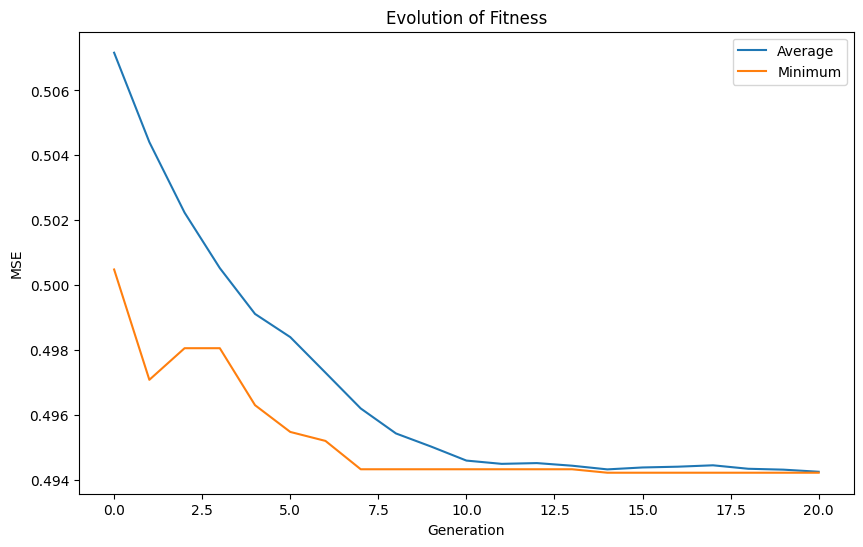

In [ ]:
import time
import random
import xgboost as xgb
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# DEAP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # We minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

def gen_genes(X_train):
    """Generate individual with at least one feature selected"""
    num_cols = X_train.shape[1]
    individual = [False] * num_cols

    # Ensure at least one feature is selected
    individual[random.randint(0, num_cols-1)] = True

    # Randomly select other features with 50% probability
    for i in range(num_cols):
        if random.random() < 0.5:
            individual[i] = True
    return individual

# Initialize toolbox
toolbox = base.Toolbox()
toolbox.register("genes", gen_genes, X_train)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.genes)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_func(individual):
    """Evaluate individual's fitness using XGBoost with GPU"""
    selected_indices = [i for i, val in enumerate(individual) if val]

    # Penalize solutions with no features or too few features
    if not selected_indices:
        return (float('inf'),)

    # Penalize solutions with too few features (optional)
    if len(selected_indices) < 3:
        return (float('inf'),)

    selected_X_train = X_train.iloc[:, selected_indices]
    selected_X_test = X_test.iloc[:, selected_indices]

    # XGBoost parameters with GPU support
    param = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Convert to DMatrix
    dtrain = xgb.DMatrix(selected_X_train, label=y_train)
    dtest = xgb.DMatrix(selected_X_test, label=y_test)

    # Train with early stopping
    evals_result = {}
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )

    # Predict and calculate MSE
    y_pred = model.predict(dtest)
    mse = mean_squared_error(y_test, y_pred)

    return (mse,)

# Register genetic operators
toolbox.register("evaluate", eval_func)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm parameters
POPULATION_SIZE = 30
MAX_GENERATIONS = 20
HALL_OF_FAME_SIZE = 5
P_CROSSOVER = 0.9
P_MUTATION = 0.1

def main():
    # Create initial population
    population = toolbox.population(n=POPULATION_SIZE)

    # Set up statistics and hall of fame
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Run the genetic algorithm
    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True
    )

    # Print results
    best_ind = hof[0]
    best_features = [X_train.columns[i] for i, val in enumerate(best_ind) if val]
    print(f"\nBest individual found with {len(best_features)} features:")
    print(f"Features: {best_features}")
    print(f"MSE: {best_ind.fitness.values[0]:.4f}")

    # Plot evolution
    gen = logbook.select("gen")
    avg = logbook.select("avg")
    min_ = logbook.select("min")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg, label="Average")
    plt.plot(gen, min_, label="Minimum")
    plt.xlabel("Generation")
    plt.ylabel("MSE")
    plt.legend()
    plt.title("Evolution of Fitness")
    plt.show()

    return best_ind, best_features

if __name__ == "__main__":
    best_ind, best_features = main()

In [ ]:
!pip install deap pyswarm pywhale xgboost matplotlib

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=b51f1fcd35ee23237336d3a40f3a67f4e1b9b95ee076a5813f36bdb299c09a1d
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7435 sha256=0e25cbab0ec2dcee7c06752a6ab7a0c3f2aa3ac30bbd50b7e2c0176623de7acf
  Stored in directory: /root/.cache/pip/wheels/a7/30/34/fceae1c718a4e749dd51f479c5720c0671519887e824915e90
Successfully built pyswarm statistics


In [ ]:
import time
import random
import math
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as pl

1. **COMMON SETUP AND EVALUATION FUNCTION**

In [ ]:
# DEAP setup for GA
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_features(feature_mask, X_train, X_test, y_train, y_test):
    """Evaluates feature subset using XGBoost with GPU acceleration."""
    selected_indices = [i for i, val in enumerate(feature_mask) if val > 0.5]

    if not selected_indices or len(selected_indices) < 3:
        return float('inf')

    param = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': 5,
        'eta': 0.1
    }

    dtrain = xgb.DMatrix(X_train.iloc[:, selected_indices], label=y_train)
    dtest = xgb.DMatrix(X_test.iloc[:, selected_indices], label=y_test)

    model = xgb.train(
        param, dtrain,
        num_boost_round=100,
        early_stopping_rounds=10,
        evals=[(dtrain, 'train'), (dtest, 'test')],
        verbose_eval=False
    )

    return mean_squared_error(y_test, model.predict(dtest))

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


**2. CUSTOM WHALE OPTIMIZATION ALGORITHM**

In [ ]:
class WOA:
    """Custom implementation of Whale Optimization Algorithm"""
    def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_whales = n_whales
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize whales
        whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
        fitness = np.array([self.func(w) for w in whales])
        best_idx = np.argmin(fitness)
        best_whale = whales[best_idx].copy()
        best_fitness = fitness[best_idx]

        # Optimization loop
        for t in range(self.max_iter):
            a = 2 - t * (2 / self.max_iter)  # a decreases linearly from 2 to 0
            a2 = -1 + t * (-1 / self.max_iter)  # a2 decreases linearly from -1 to -2

            for i in range(self.n_whales):
                r1, r2 = np.random.rand(), np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1  # Spiral constant
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()

                if p < 0.5:
                    if abs(A) < 1:
                        # Encircling prey
                        D = abs(C * best_whale - whales[i])
                        whales[i] = best_whale - A * D
                    else:
                        # Search for prey
                        rand_idx = np.random.randint(0, self.n_whales)
                        rand_whale = whales[rand_idx]
                        D = abs(C * rand_whale - whales[i])
                        whales[i] = rand_whale - A * D
                else:
                    # Bubble-net attacking
                    D = abs(best_whale - whales[i])
                    whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

                # Apply bounds
                whales[i] = np.clip(whales[i], self.lb, self.ub)

                # Evaluate new solution
                fitness[i] = self.func(whales[i])

                # Update best
                if fitness[i] < best_fitness:
                    best_whale = whales[i].copy()
                    best_fitness = fitness[i]

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_whale, best_fitness

**# 2. SQUID GAME OPTIMIZER (SGO) IMPLEMENTATION**

In [ ]:
class SquidGameOptimizer:
    """Enhanced SGO with offensive/defensive strategies and elimination rounds."""
    def __init__(self, func, dim, lb, ub, n_players=30, max_games=20):
        self.func = func
        self.dim = dim
        self.lb = lb
        self.ub = ub
        self.n_players = n_players
        self.max_games = max_games
        self.history = {'mse': [], 'time': []}

    def optimize(self):
        start_time = time.time()

        # Initialize players with roles (0=defensive, 1=offensive)
        players = np.random.uniform(self.lb, self.ub, (self.n_players, self.dim))
        roles = np.random.randint(0, 2, self.n_players)
        fitness = np.array([self.func(p) for p in players])
        best_idx = np.argmin(fitness)
        best_player = players[best_idx].copy()
        best_fitness = fitness[best_idx]

        for game in range(self.max_games):
            new_players = np.zeros_like(players)
            elimination_prob = 0.2 + (0.5 * game / self.max_games)  # Increasing elimination pressure

            for i in range(self.n_players):
                if roles[i] == 1:  # Offensive player
                    # Aggressive move toward best player with momentum
                    A = np.random.uniform(0.5, 1.5, self.dim)
                    new_players[i] = np.clip(best_player * A, self.lb, self.ub)
                else:  # Defensive player
                    # Local search with adaptive step size
                    step = np.random.normal(0, 0.5*(1-game/self.max_games), self.dim)
                    new_players[i] = np.clip(players[i] + step, self.lb, self.ub)

                # Role adaptation
                if random.random() < 0.1:  # 10% chance to switch roles
                    roles[i] = 1 - roles[i]

            # Evaluate and apply elimination
            for i in range(self.n_players):
                new_fitness = self.func(new_players[i])

                # Survival condition
                if (new_fitness < fitness[i] or
                    random.random() > elimination_prob or
                    (roles[i] == 1 and new_fitness < 1.1*best_fitness)):

                    players[i] = new_players[i]
                    fitness[i] = new_fitness

                    if new_fitness < best_fitness:
                        best_player = new_players[i].copy()
                        best_fitness = new_fitness

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

        return best_player, best_fitness

In [ ]:
class PSH_Hyptrite:
    """Fixed implementation with bounds checking"""
    def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
        self.func = func
        self.dim = dim
        self.lb = np.array(lb)  # Convert to numpy array
        self.ub = np.array(ub)  # Convert to numpy array
        self.n_points = n_points
        self.max_iter = max_iter
        self.history = {'mse': [], 'time': []}

    def hypersphere_sampling(self, center, radius, n_samples):
        """Generates points on hypersphere surface with bounds checking"""
        points = np.random.normal(size=(n_samples, self.dim))
        points = points / np.linalg.norm(points, axis=1)[:, np.newaxis]
        new_points = center + radius * points
        return np.clip(new_points, self.lb, self.ub)

    def optimize(self):
        start_time = time.time()

        # Initialize within bounds
        points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
        fitness = np.array([self.func(p) for p in points])
        best_idx = np.argmin(fitness)
        best_point = points[best_idx].copy()
        best_fitness = fitness[best_idx]

        initial_radius = 0.5 * np.mean(self.ub - self.lb)  # Fixed radius calculation

        for iter in range(self.max_iter):
            radius = initial_radius * (1 - iter/self.max_iter)

            # Generate new points
            new_points = []
            for p in points:
                hs_points = self.hypersphere_sampling(p, radius, 3)
                new_points.extend(hs_points)

            # Evaluate and combine
            new_points = np.array(new_points)
            new_fitness = np.array([self.func(p) for p in new_points])

            all_points = np.vstack([points, new_points])
            all_fitness = np.concatenate([fitness, new_fitness])

            # Select best
            best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
            points = all_points[best_indices]
            fitness = all_fitness[best_indices]

            # Update best
            current_best = np.min(fitness)
            if current_best < best_fitness:
                best_fitness = current_best
                best_point = points[np.argmin(fitness)].copy()

            self.history['mse'].append(best_fitness)
            self.history['time'].append(time.time() - start_time)

            print(f"Iter {iter+1}/{self.max_iter} | Best MSE: {best_fitness:.6f}", end='\r')

        print(f"\nOptimization completed in {time.time()-start_time:.2f}s")
        return best_point, best_fitness

**3. ALGORITHM IMPLEMENTATIONS (ONE-BY-ONE)**

In [ ]:
def run_genetic_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced GA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== GENETIC ALGORITHM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population size: 30")
        print(f"- Generations: 20")
        print(f"- Crossover rate: 80%")
        print(f"- Mutation rate: 20%")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup evolutionary toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.random)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", lambda ind: (evaluate_features(ind, X_train, X_test, y_train, y_test),))
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # 3. Initialize population
    population = toolbox.population(n=30)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("time", lambda _: time.time() - start_time)

    # 4. Evolutionary loop with progress tracking
    logbook = tools.Logbook()
    print("[Evolution Progress]")
    for gen in range(20):
        # Evolve population
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.8, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)

        # Update fitness
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Selection
        population = toolbox.select(offspring, k=len(population))
        hof.update(population)

        # Record stats
        record = stats.compile(population)
        logbook.record(gen=gen, **record)

        # Print progress every 5 generations
        if gen % 5 == 0 or gen == 19:
            print(f"Gen {gen+1:02d}/20 | Best MSE: {record['min']:.6f} | Avg MSE: {record['avg']:.6f}")

    # 5. Results extraction
    best_ind = hof[0]
    best_mask = [x > 0.5 for x in best_ind]
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])
    elapsed = time.time() - start_time

    # 6. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_ind.fitness.values[0]:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 7. Convergence analysis
    if logbook:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {logbook[0]['min']:.4f}")
        print(f"- Final MSE: {logbook[-1]['min']:.4f}")
        improvement = 100*(logbook[0]['min']-logbook[-1]['min'])/logbook[0]['min']
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(logbook.select('gen'), logbook.select('min'), 'b-o', label='Best')
        plt.plot(logbook.select('gen'), logbook.select('avg'), 'r--', label='Average')
        plt.title('GA Convergence')
        plt.xlabel('Generation')
        plt.ylabel('MSE')
        plt.legend()
        plt.grid(True)
        plt.show()

    return {
        'mse': best_ind.fitness.values[0],
        'features': selected_features,
        'time': elapsed,
        'history': logbook
    }

In [ ]:
def run_pso_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Complete Particle Swarm Optimization implementation for feature selection"""
    print("\n" + "="*50)
    print("=== PARTICLE SWARM OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Swarm size: 30 particles")
        print(f"- Iterations: 20")
        print(f"- Cognitive weight: 0.5")
        print(f"- Social weight: 0.5")
        print(f"- Inertia weight: 0.5")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': [], 'iterations': []}
    iteration = [0]  # Using list to allow modification in nested function

    # 3. Enhanced objective function with progress tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

        # Track all evaluations
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))

        # Only count complete iterations (swarmsize evaluations = 1 iteration)
        if len(history['mse']) % 30 == 0:
            iteration[0] += 1
            history['iterations'].append({
                'iteration': iteration[0],
                'mse': mse,
                'time': time.time() - start_time
            })
            if verbose and (iteration[0] % 5 == 0 or iteration[0] == 1):
                print(f"Iteration {iteration[0]}: Best MSE = {mse:.6f}")

        return mse

    # 4. Run PSO with corrected parameters
    print("[Optimization Progress]")
    best_mask, best_mse = pso(
        objective,
        lb, ub,
        swarmsize=30,
        maxiter=20,
        phip=0.5,  # cognitive parameter
        phig=0.5,  # social parameter
        omega=0.5,  # inertia
        minstep=1e-4,
        minfunc=1e-4,
        debug=True  # Use pyswarm's built-in progress
    )

    # 5. Post-process results
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    # Ensure minimum 3 features are selected
    if len(selected_indices) < 3:
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 6. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 7. Enhanced convergence visualization
    if history['iterations']:
        plt.figure(figsize=(12, 5))

        # MSE vs Iterations
        plt.subplot(1, 2, 1)
        iterations = [x['iteration'] for x in history['iterations']]
        mses = [x['mse'] for x in history['iterations']]
        plt.plot(iterations, mses, 'b-o', linewidth=2)
        plt.title('PSO Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        # Time vs MSE
        plt.subplot(1, 2, 2)
        times = [x['time'] for x in history['iterations']]
        plt.plot(times, mses, 'r-', linewidth=2)
        plt.title('Optimization Progress')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

In [ ]:
def run_woa_algorithm(X_train, X_test, y_train, y_test, verbose=True):
    """Enhanced WOA with detailed progress tracking and reporting"""
    print("\n" + "="*50)
    print("=== WHALE OPTIMIZATION ALGORITHM ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Population: 30 whales")
        print(f"- Max iterations: 20")
        print(f"- Spiral coefficient (b): 1.0")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. WOA Implementation
    class EnhancedWOA:
        def __init__(self, func, dim, lb, ub, n_whales=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_whales = n_whales
            self.max_iter = max_iter
            self.b = 1.0  # Spiral coefficient

        def optimize(self):
            # Initialize whales
            whales = np.random.uniform(self.lb, self.ub, (self.n_whales, self.dim))
            fitness = np.array([self.func(w) for w in whales])
            best_idx = np.argmin(fitness)
            best_whale = whales[best_idx].copy()
            best_fitness = fitness[best_idx]

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                a = 2 - iter * (2 / self.max_iter)  # a decreases linearly 2→0
                a2 = -1 + iter * (-1 / self.max_iter)  # a2 decreases linearly -1→-2

                for i in range(self.n_whales):
                    r1, r2 = np.random.rand(), np.random.rand()
                    A = 2 * a * r1 - a
                    C = 2 * r2
                    l = (a2 - 1) * np.random.rand() + 1
                    p = np.random.rand()

                    if p < 0.5:
                        if abs(A) < 1:
                            # Encircling prey
                            D = abs(C * best_whale - whales[i])
                            whales[i] = best_whale - A * D
                        else:
                            # Search for prey
                            rand_idx = np.random.randint(0, self.n_whales)
                            rand_whale = whales[rand_idx]
                            D = abs(C * rand_whale - whales[i])
                            whales[i] = rand_whale - A * D
                    else:
                        # Bubble-net attacking
                        D = abs(best_whale - whales[i])
                        whales[i] = D * np.exp(self.b * l) * np.cos(2 * np.pi * l) + best_whale

                    # Boundary check
                    whales[i] = np.clip(whales[i], self.lb, self.ub)

                    # Evaluate new solution
                    fitness[i] = self.func(whales[i])

                    # Update best
                    if fitness[i] < best_fitness:
                        best_whale = whales[i].copy()
                        best_fitness = fitness[i]

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_whale, best_fitness

    # 5. Run optimization
    optimizer = EnhancedWOA(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_whales=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Results extraction
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Detailed reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 8. Convergence analysis
    if history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {history['mse'][0]:.4f}")
        print(f"- Final MSE: {history['mse'][-1]:.4f}")
        improvement = 100*(history['mse'][0]-history['mse'][-1])/history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('WOA Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': history
    }


In [ ]:
def run_sgo(X_train, X_test, y_train, y_test, verbose=True):
    """Runs Squid Game Optimizer with detailed printing"""
    print("\n" + "="*50)
    print("=== SQUID GAME OPTIMIZER (SGO) ===")
    print("="*50 + "\n")

    start_time = time.time()

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Players: 30 (15 offensive, 15 defensive)")
        print(f"- Max games: 20")
        print(f"- Search space: {X_train.shape[1]} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Optimization
    def objective(feature_mask):
        return evaluate_features(feature_mask, X_train, X_test, y_train, y_test)

    optimizer = SquidGameOptimizer(
        func=objective,
        dim=X_train.shape[1],
        lb=0, ub=1,
        n_players=30,
        max_games=20
    )

    best_mask, best_mse = optimizer.optimize()
    elapsed = time.time() - start_time

    # 3. Results
    selected_features = [X_train.columns[i] for i, val in enumerate(best_mask) if val > 0.5]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/X_train.shape[1])

    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{X_train.shape[1]} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")

    # 4. Convergence Analysis
    if optimizer.history['mse']:
        print("\n▶ Convergence progress:")
        print(f"- Initial MSE: {optimizer.history['mse'][0]:.4f}")
        print(f"- Final MSE: {optimizer.history['mse'][-1]:.4f}")
        improvement = 100*(optimizer.history['mse'][0]-optimizer.history['mse'][-1])/optimizer.history['mse'][0]
        print(f"- Improvement: {improvement:.1f}%")

        plt.figure(figsize=(10,5))
        plt.plot(optimizer.history['mse'], 'b-o', linewidth=2)
        plt.title('SGO Convergence')
        plt.xlabel('Game Round')
        plt.ylabel('MSE')
        plt.grid(True)
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'time': elapsed,
        'history': optimizer.history
    }

In [ ]:
def run_psh_hyptrite(X_train, X_test, y_train, y_test, verbose=True):
    """Complete PSH-Hyptrite optimization for feature selection"""
    print("\n" + "="*50)
    print("=== PSH-HYPTRITE OPTIMIZATION ===")
    print("="*50 + "\n")

    start_time = time.time()
    n_features = X_train.shape[1]

    # 1. Initialization
    if verbose:
        print("[Initialization]")
        print(f"- Search points: 30")
        print(f"- Max iterations: 20")
        print(f"- Initial radius: 0.5 (adaptive)")
        print(f"- Hypersphere samples: 3 per point")
        print(f"- Search space: {n_features} features")
        print(f"- Target: Minimize MSE using XGBoost\n")

    # 2. Setup bounds and history tracking
    lb = [0] * n_features
    ub = [1] * n_features
    history = {'mse': [], 'time': [], 'features': []}

    # 3. Objective function with tracking
    def objective(feature_mask):
        mse = evaluate_features(feature_mask, X_train, X_test, y_train, y_test)
        history['mse'].append(mse)
        history['time'].append(time.time() - start_time)
        history['features'].append(np.sum(feature_mask > 0.5))
        return mse

    # 4. PSH-Hyptrite Implementation
    class EnhancedPSH:
        def __init__(self, func, dim, lb, ub, n_points=30, max_iter=20):
            self.func = func
            self.dim = dim
            self.lb = np.array(lb)
            self.ub = np.array(ub)
            self.n_points = n_points
            self.max_iter = max_iter
            self.hs_samples = 3  # Hypersphere sampling points

        def hypersphere_sampling(self, center, radius, n_samples):
            """Generates points on hypersphere surface with bounds checking"""
            points = np.random.normal(size=(n_samples, self.dim))
            norms = np.linalg.norm(points, axis=1)[:, np.newaxis]
            points = points / np.where(norms == 0, 1, norms)  # Avoid division by zero
            new_points = center + radius * points
            return np.clip(new_points, self.lb, self.ub)

        def optimize(self):
            # Initialize search points
            points = np.random.uniform(self.lb, self.ub, (self.n_points, self.dim))
            fitness = np.array([self.func(p) for p in points])
            best_idx = np.argmin(fitness)
            best_point = points[best_idx].copy()
            best_fitness = fitness[best_idx]

            initial_radius = 0.5 * np.mean(self.ub - self.lb)

            print("[Optimization Progress]")
            for iter in range(self.max_iter):
                # Current adaptive radius
                radius = initial_radius * (1 - iter/self.max_iter)

                # Generate new points via hypersphere sampling
                new_points = []
                for p in points:
                    hs_points = self.hypersphere_sampling(p, radius, self.hs_samples)
                    new_points.extend(hs_points)
                new_points = np.array(new_points)

                # Evaluate new points
                new_fitness = np.array([self.func(p) for p in new_points])

                # Combine with previous points
                all_points = np.vstack([points, new_points])
                all_fitness = np.concatenate([fitness, new_fitness])

                # Select best n_points for next iteration
                best_indices = np.argpartition(all_fitness, self.n_points)[:self.n_points]
                points = all_points[best_indices]
                fitness = all_fitness[best_indices]

                # Update global best
                current_best = np.min(fitness)
                if current_best < best_fitness:
                    best_fitness = current_best
                    best_point = points[np.argmin(fitness)].copy()

                # Print progress every 5 iterations
                if iter % 5 == 0 or iter == self.max_iter - 1:
                    print(f"Iter {iter+1:02d}/{self.max_iter} | Best MSE: {best_fitness:.6f} | Radius: {radius:.4f}",
                          end='\r' if iter != self.max_iter - 1 else '\n')

            return best_point, best_fitness

    # 5. Run optimization
    optimizer = EnhancedPSH(
        func=objective,
        dim=n_features,
        lb=lb,
        ub=ub,
        n_points=30,
        max_iter=20
    )
    best_mask, best_mse = optimizer.optimize()

    # 6. Post-process results to ensure at least 3 features
    best_mask = np.array(best_mask)
    selected_indices = np.where(best_mask > 0.5)[0]

    if len(selected_indices) < 3:
        # Fallback to top 3 features by weight
        selected_indices = np.argsort(best_mask)[-3:]
        best_mask = np.zeros_like(best_mask)
        best_mask[selected_indices] = 1
        best_mse = objective(best_mask)  # Re-evaluate with enforced features

    selected_features = [X_train.columns[i] for i in selected_indices]
    n_selected = len(selected_features)
    reduction = 100 * (1 - n_selected/n_features)
    elapsed = time.time() - start_time

    # 7. Results reporting
    print("\n" + "="*50)
    print("=== OPTIMIZATION RESULTS ===")
    print("="*50)
    print(f"\n▶ Best MSE achieved: {best_mse:.6f}")
    print(f"▶ Time elapsed: {elapsed:.2f} seconds")
    print(f"▶ Features selected: {n_selected}/{n_features} ({reduction:.1f}% reduction)")

    print("\n▶ Selected features (with weights):")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat} (weight: {best_mask[selected_indices[i-1]]:.3f})")

    # 8. Convergence visualization
    if history['mse']:
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history['mse'], 'b-o', linewidth=2)
        plt.title('PSH-Hyptrite Convergence')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.subplot(1,2,2)
        plt.plot(history['time'], history['mse'], 'r-', linewidth=2)
        plt.title('Time vs Performance')
        plt.xlabel('Time (s)')
        plt.ylabel('MSE')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return {
        'mse': best_mse,
        'features': selected_features,
        'feature_weights': best_mask,
        'time': elapsed,
        'history': history
    }

**4. COMPARISON AND VISUALIZATION**

In [ ]:
def compare_algorithms(X_train, X_test, y_train, y_test):
    """Runs all algorithms and generates comprehensive visualizations."""
    """Runs all algorithms with proper bounds handling"""
    n_features = X_train.shape[1]

    # Convert bounds to lists for PSH-Hyptrite
    lb = [0] * n_features
    ub = [1] * n_features

    results = {
        'GA': run_genetic_algorithm(X_train, X_test, y_train, y_test),
        'PSO': run_pso_algorithm(X_train, X_test, y_train, y_test),
        'WOA': run_woa_algorithm(X_train, X_test, y_train, y_test),
        'SGO': run_sgo(X_train, X_test, y_train, y_test),
        'PSH-Hyptrite': run_psh_hyptrite(X_train, X_test, y_train, y_test)
    }

    # Create comparison dashboard
    plt.figure(figsize=(20, 15))

    # Plot 1: Convergence Curves
    plt.subplot(2, 3, 1)
    for algo, res in results.items():
        if 'history' in res and 'mse' in res['history']:
            plt.plot(res['history']['mse'], label=algo)
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('Convergence Curves')
    plt.legend()
    plt.grid(True)

    # Plot 2: Execution Time Profile
    plt.subplot(2, 3, 2)
    for algo, res in results.items():
        if 'history' in res and 'time' in res['history']:
            plt.plot(res['history']['time'], res['history']['mse'], label=algo)
    plt.xlabel('Time (s)')
    plt.ylabel('MSE')
    plt.title('Time vs Performance')
    plt.legend()
    plt.grid(True)

    # Plot 3: Final MSE Comparison
    plt.subplot(2, 3, 3)
    plt.bar(results.keys(), [res['mse'] for res in results.values()])
    plt.ylabel('MSE')
    plt.title('Final Model Performance')
    plt.xticks(rotation=45)

    # Plot 4: Feature Selection Count
    plt.subplot(2, 3, 4)
    plt.bar(results.keys(), [len(res['features']) for res in results.values()])
    plt.ylabel('Number of Features')
    plt.title('Feature Selection Count')
    plt.xticks(rotation=45)

    # Plot 5: Feature Selection Overlap
    plt.subplot(2, 3, 5)
    all_features = X_train.columns
    for algo, res in results.items():
        selected = [1 if f in res['features'] else 0 for f in all_features]
        plt.plot(selected, 'o-', label=algo, alpha=0.7)
    plt.xticks(range(len(all_features)), all_features, rotation=90)
    plt.ylabel('Selection (1=selected)')
    plt.title('Feature Selection Patterns')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    return results

**5. EXECUTION EXAMPLE**


=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.504423
New best for swarm at iteration 1: [0.84721144 0.95447224 0.69116778 0.18843259 0.87474636 1.
 0.58245284 0.76013275 0.51768394 0.87148848 0.71972752 0.85838279
 1.         0.5609948 ] 0.4970822334289551
Best after iteration 1: [0.84721144 0.95447224 0.69116778 0.18843259 0.87474636 1.
 0.58245284 0.76013275 0.51768394 0.87148848 0.71972752 0.85838279
 1.         0.5609948 ] 0.4970822334289551
Best after iteration 2: [0.84721144 0.95447224 0.69116778 0.18843259 0.87474636 1.
 0.58245284 0.76013275 0.51768394 0.87148848 0.71972752 0.85838279
 1.         0.5609948 ] 0.4970822334289551
New best for swarm at iteration 3: [0.99029578 0.90239923 1.         0.60280888 1.         1.
 0.02

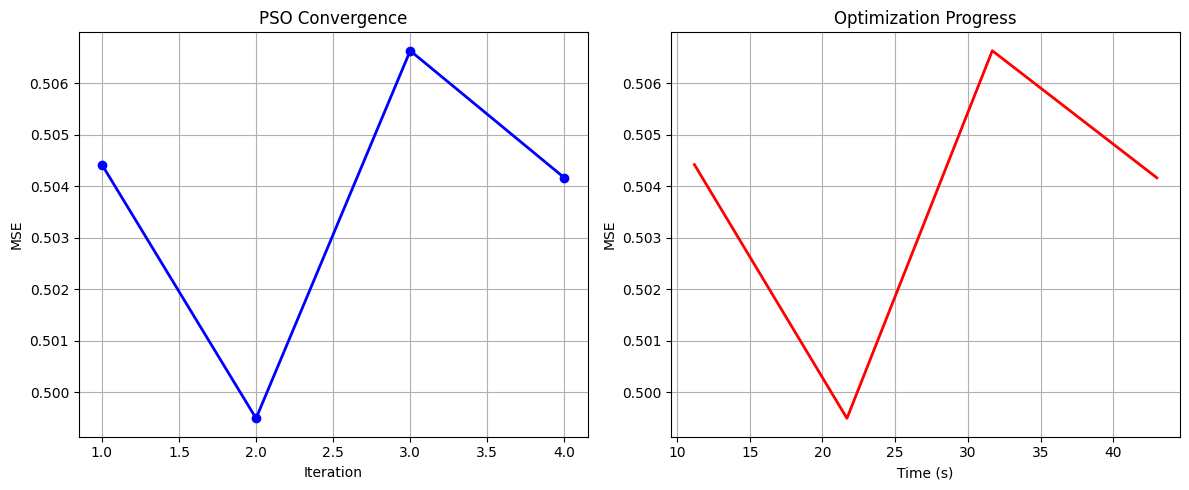


=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.494712 | Radius: 0.0250

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494712
▶ Time elapsed: 727.67 seconds
▶ Features selected: 13/14 (7.1% reduction)

▶ Selected features (with weights):
1. 0 (weight: 0.864)
2. 1 (weight: 0.781)
3. 2 (weight: 0.598)
4. 3 (weight: 0.631)
5. 4 (weight: 0.632)
6. 5 (weight: 0.996)
7. 6 (weight: 0.912)
8. 8 (weight: 0.893)
9. 9 (weight: 0.804)
10. 10 (weight: 0.758)
11. 11 (weight: 0.850)
12. 12 (weight: 0.924)
13. 13 (weight: 1.000)


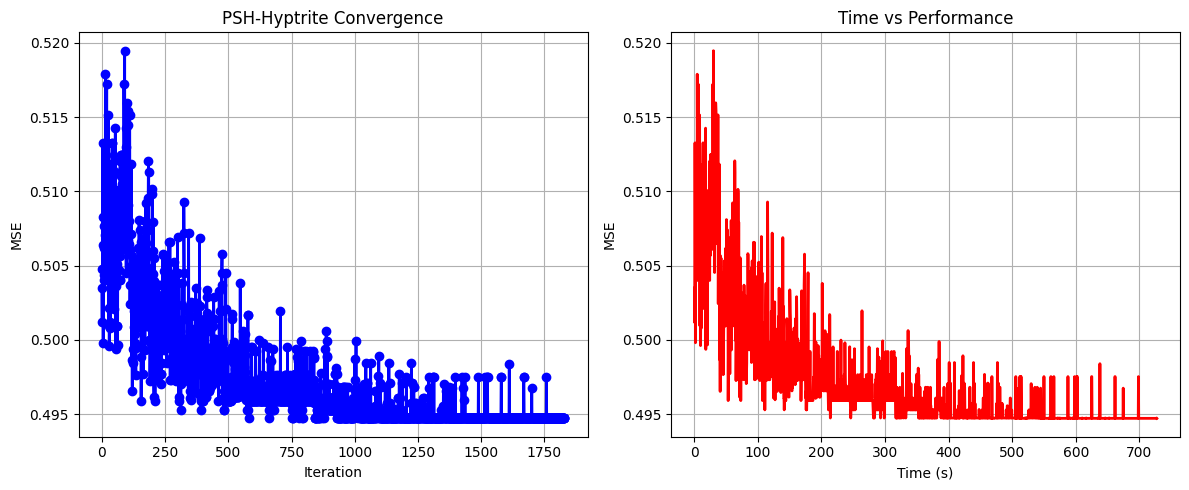

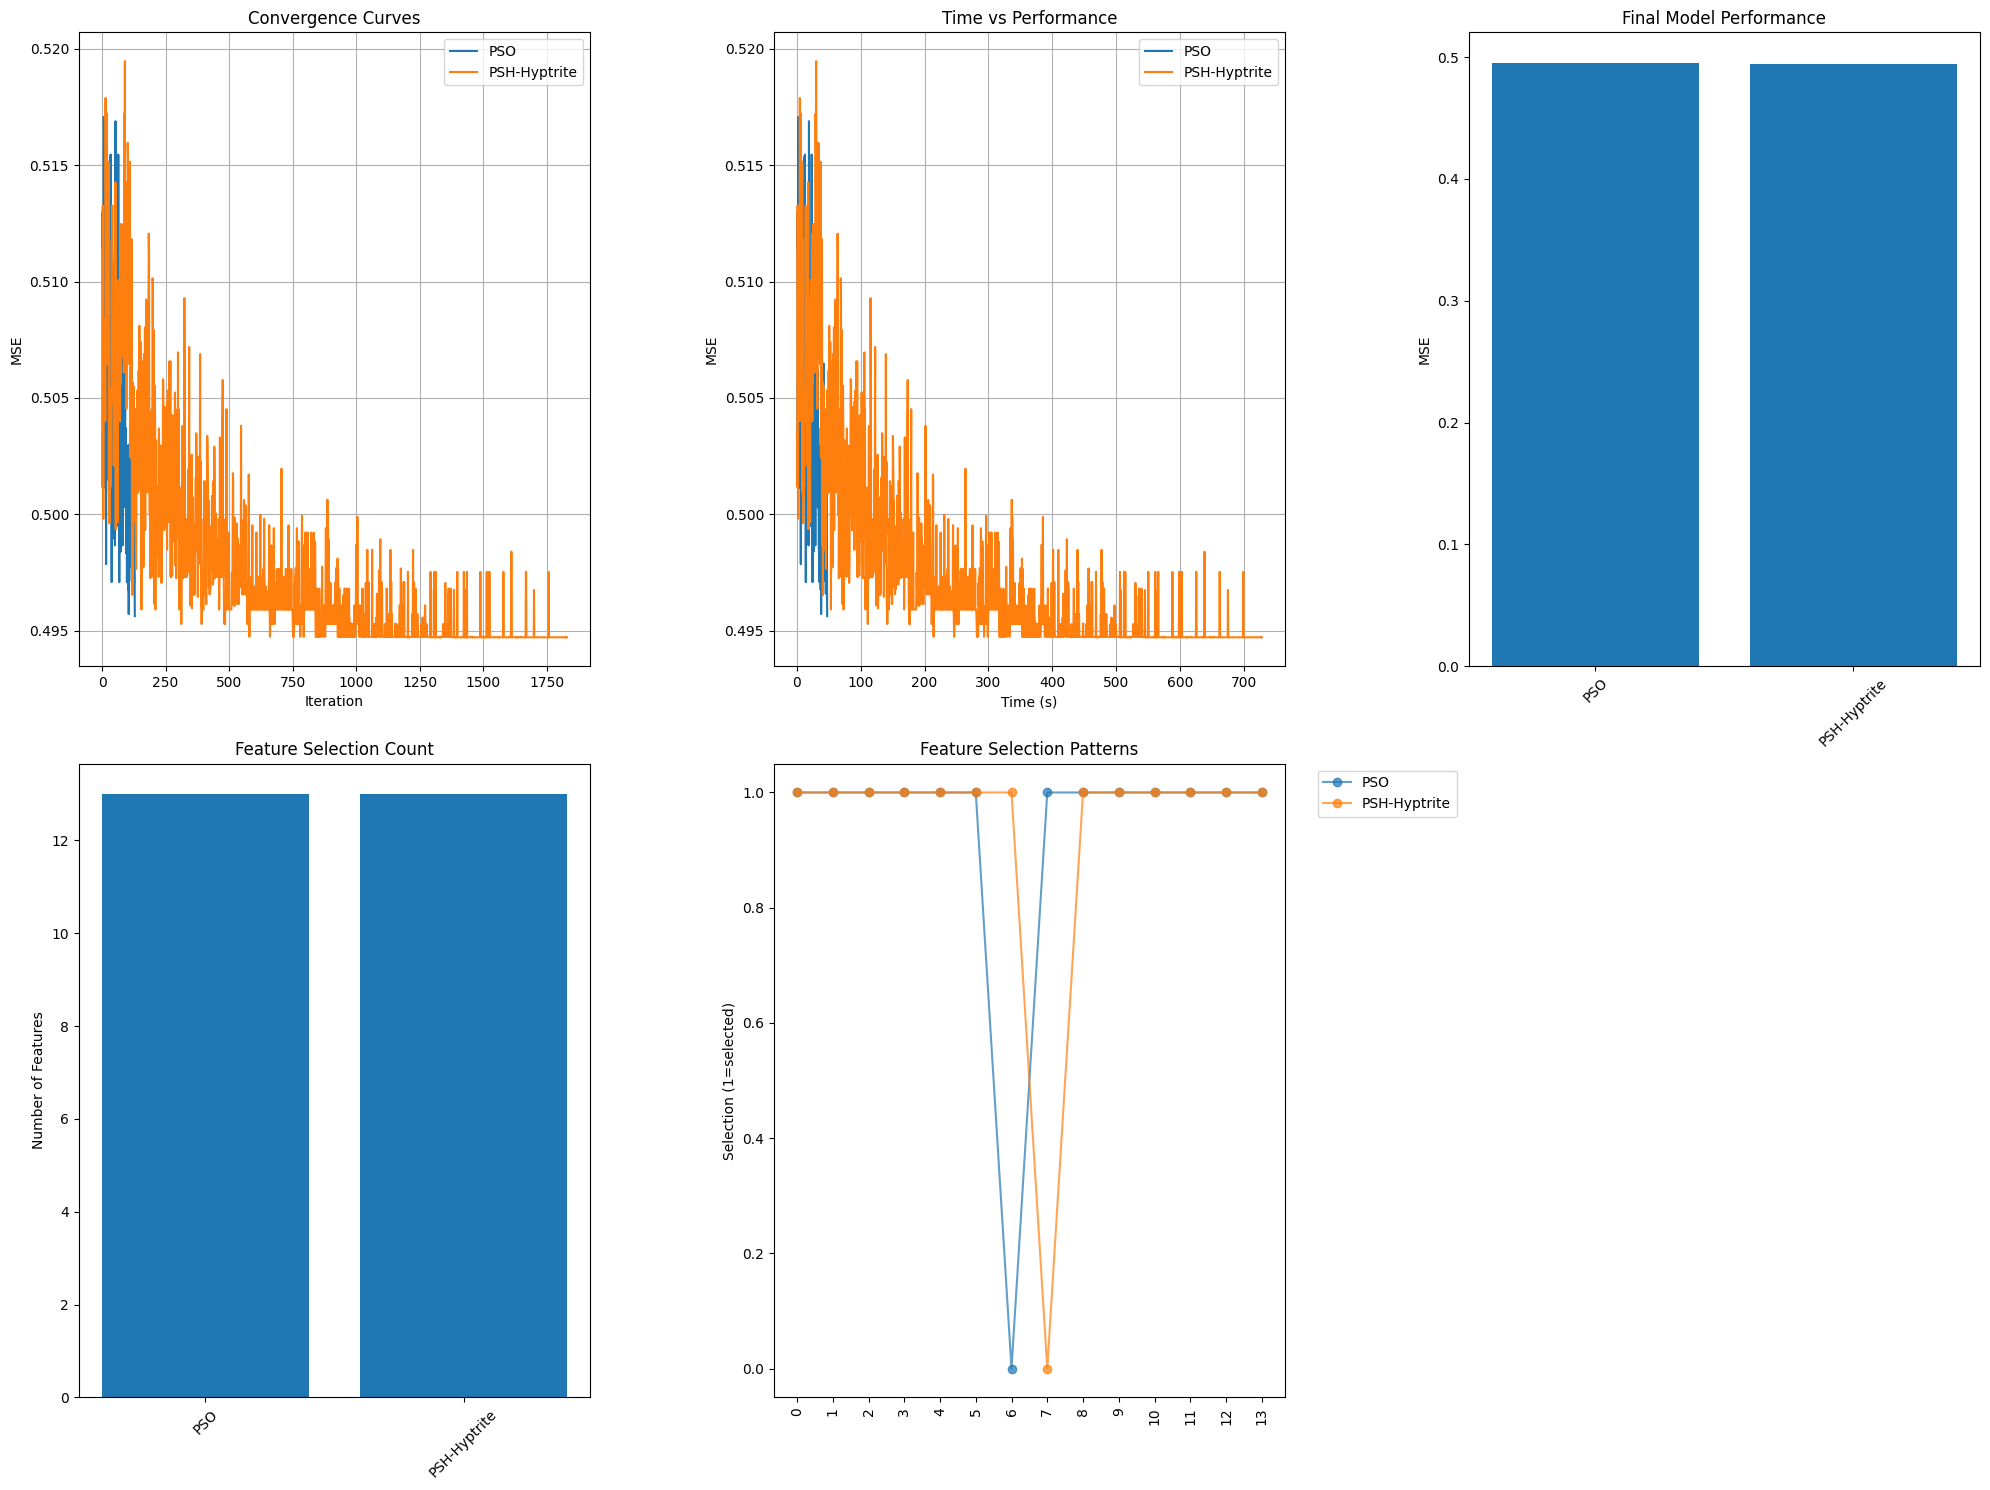

In [ ]:
final_results = compare_algorithms(X_train, X_test, y_train, y_test)

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from deap import base, creator, tools, algorithms
from pyswarm import pso

def select_best_algorithm(X_train, X_test, y_train, y_test):
    """
    Automatically runs and compares optimization algorithms for feature selection,
    then returns the best performing algorithm's results.
    """
    # Dictionary to store all results
    results = {}

    # List of available algorithms (with their display names and functions)
    algorithms_to_run = [
        ('Genetic Algorithm', run_genetic_algorithm),
        ('Particle Swarm Optimization', run_pso_algorithm),
        ('Whale Optimization', run_woa_algorithm),
        ('Squid Game Optimizer', run_sgo),
        ('PSH-Hyptrite', run_psh_hyptrite)
    ]

    # Run each algorithm and store results
    for name, algorithm in algorithms_to_run:
        print(f"\n{'='*50}")
        print(f"Running {name}...")
        print(f"{'='*50}")
        try:
            results[name] = algorithm(X_train, X_test, y_train, y_test)
            print(f"{name} completed successfully with MSE: {results[name]['mse']:.4f}")
        except Exception as e:
            print(f"Error running {name}: {str(e)}")
            results[name] = None

    # Filter out failed algorithms
    valid_results = {k: v for k, v in results.items() if v is not None}

    if not valid_results:
        raise RuntimeError("All algorithms failed to run successfully")

    # Find the best algorithm (lowest MSE)
    best_algo_name = min(valid_results.keys(), key=lambda x: valid_results[x]['mse'])
    best_result = valid_results[best_algo_name]

    # Generate comparison report
    generate_comparison_report(valid_results, best_algo_name)

    return {
        'best_algorithm': best_algo_name,
        'best_mse': best_result['mse'],
        'selected_features': best_result['features'],
        'execution_time': best_result['time'],
        'all_results': valid_results
    }

def generate_comparison_report(results, best_algo_name):
    """Generates visual comparison of all algorithms"""
    plt.figure(figsize=(15, 10))

    # 1. MSE Comparison
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    mses = [results[name]['mse'] for name in names]
    colors = ['green' if name == best_algo_name else 'blue' for name in names]
    plt.bar(names, mses, color=colors)
    plt.title('Algorithm Performance Comparison')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 2. Execution Time
    plt.subplot(2, 2, 2)
    times = [results[name]['time'] for name in names]
    plt.bar(names, times, color=colors)
    plt.title('Execution Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 3. Feature Selection Count
    plt.subplot(2, 2, 3)
    feature_counts = [len(results[name]['features']) for name in names]
    plt.bar(names, feature_counts, color=colors)
    plt.title('Number of Selected Features')
    plt.ylabel('Feature Count')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')

    # 4. Convergence Plot
    plt.subplot(2, 2, 4)
    for name, result in results.items():
        if 'history' in result and 'mse' in result['history']:
            plt.plot(result['history']['mse'],
                    label=f"{name} (final: {result['mse']:.4f})",
                    linewidth=2 if name == best_algo_name else 1)
    plt.title('Convergence Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    print(f"\n🏆 Best Algorithm: {best_algo_name}")
    print(f"📉 Best MSE Achieved: {results[best_algo_name]['mse']:.6f}")
    print(f"⏱️ Execution Time: {results[best_algo_name]['time']:.2f} seconds")
    print(f"🔢 Features Selected: {len(results[best_algo_name]['features'])}")
    print("\nSelected Features:")
    for i, feat in enumerate(results[best_algo_name]['features'], 1):
        print(f"{i}. {feat}")

# Example usage:
# best_results = select_best_algorithm(X_train, X_test, y_train, y_test)


Running Genetic Algorithm...

=== GENETIC ALGORITHM OPTIMIZATION ===

[Initialization]
- Population size: 30
- Generations: 20
- Crossover rate: 80%
- Mutation rate: 20%
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Evolution Progress]
Gen 01/20 | Best MSE: 0.499205 | Avg MSE: 0.503631
Gen 06/20 | Best MSE: 0.494734 | Avg MSE: 0.496227
Gen 11/20 | Best MSE: 0.494734 | Avg MSE: 0.494734
Gen 16/20 | Best MSE: 0.494734 | Avg MSE: 0.494734
Gen 20/20 | Best MSE: 0.494712 | Avg MSE: 0.494752

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494712
▶ Time elapsed: 242.81 seconds
▶ Features selected: 13/14 (7.1% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 8
9. 9
10. 10
11. 11
12. 12
13. 13

▶ Convergence progress:
- Initial MSE: 0.4992
- Final MSE: 0.4947
- Improvement: 0.9%


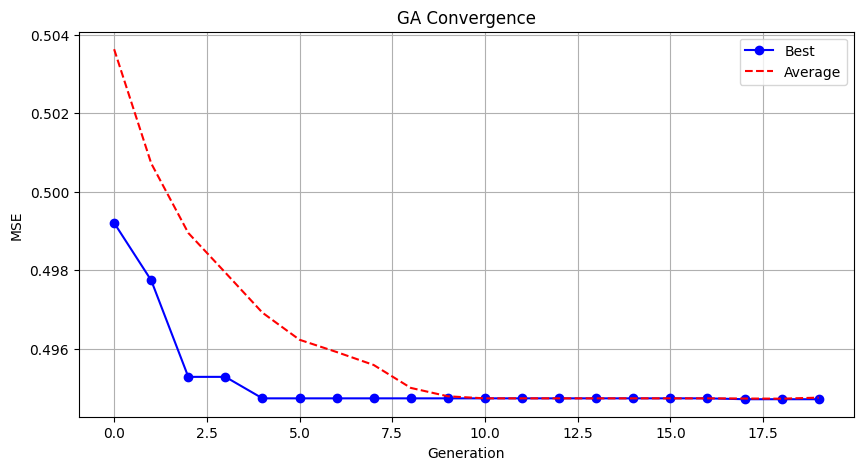

Genetic Algorithm completed successfully with MSE: 0.4947

Running Particle Swarm Optimization...

=== PARTICLE SWARM OPTIMIZATION ===

[Initialization]
- Swarm size: 30 particles
- Iterations: 20
- Cognitive weight: 0.5
- Social weight: 0.5
- Inertia weight: 0.5
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
No constraints given.
Iteration 1: Best MSE = 0.523035
New best for swarm at iteration 1: [0.89063224 0.68652499 0.8485497  0.60297246 0.72689159 1.
 0.04850203 0.93343372 0.70077581 0.43037542 0.79626602 0.64278818
 0.64473479 0.21950079] 0.49868056178092957
New best for swarm at iteration 1: [1.         1.         0.90670965 0.61119521 0.98483405 0.64514122
 0.         0.61410375 1.         0.50592588 0.93074294 0.6671887
 0.48675218 0.58087047] 0.4981863498687744
Best after iteration 1: [1.         1.         0.90670965 0.61119521 0.98483405 0.64514122
 0.         0.61410375 1.         0.50592588 0.93074294 0.6671887
 0.48675218 0.5808

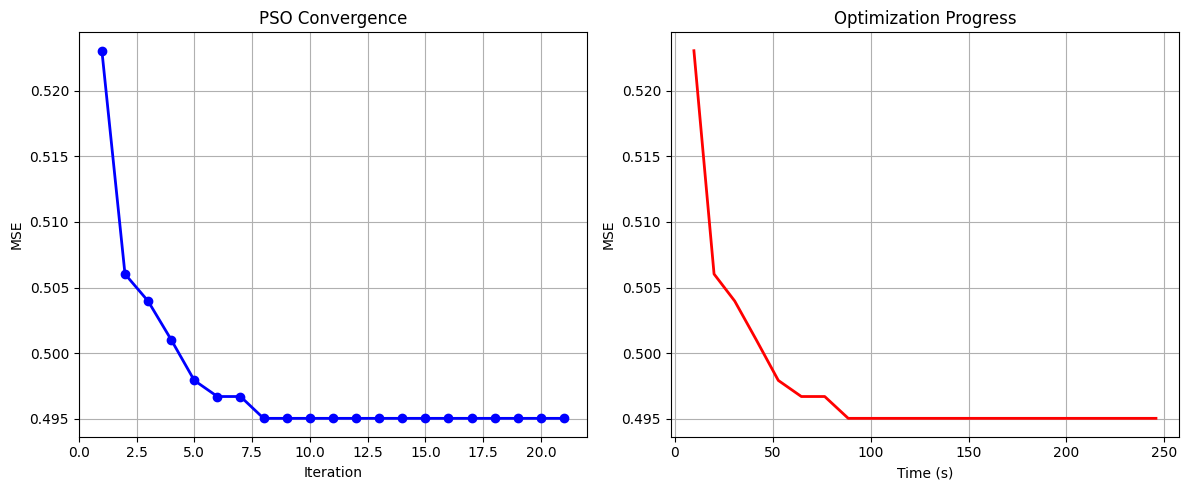

Particle Swarm Optimization completed successfully with MSE: 0.4946

Running Whale Optimization...

=== WHALE OPTIMIZATION ALGORITHM ===

[Initialization]
- Population: 30 whales
- Max iterations: 20
- Spiral coefficient (b): 1.0
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.494734

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494734
▶ Time elapsed: 241.04 seconds
▶ Features selected: 14/14 (0.0% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 8
10. 9
11. 10
12. 11
13. 12
14. 13

▶ Convergence progress:
- Initial MSE: 0.5106
- Final MSE: 0.4947
- Improvement: 3.1%


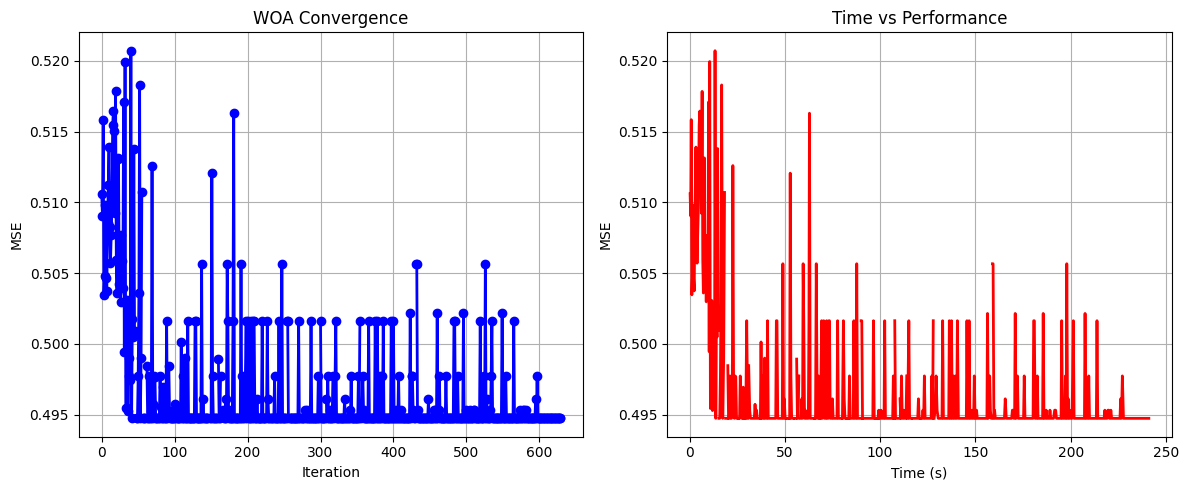

Whale Optimization completed successfully with MSE: 0.4947

Running Squid Game Optimizer...

=== SQUID GAME OPTIMIZER (SGO) ===

[Initialization]
- Players: 30 (15 offensive, 15 defensive)
- Max games: 20
- Search space: 14 features
- Target: Minimize MSE using XGBoost


=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.495728
▶ Time elapsed: 223.85 seconds
▶ Features selected: 13/14 (7.1% reduction)

▶ Selected features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 6
7. 7
8. 8
9. 9
10. 10
11. 11
12. 12
13. 13

▶ Convergence progress:
- Initial MSE: 0.4988
- Final MSE: 0.4957
- Improvement: 0.6%


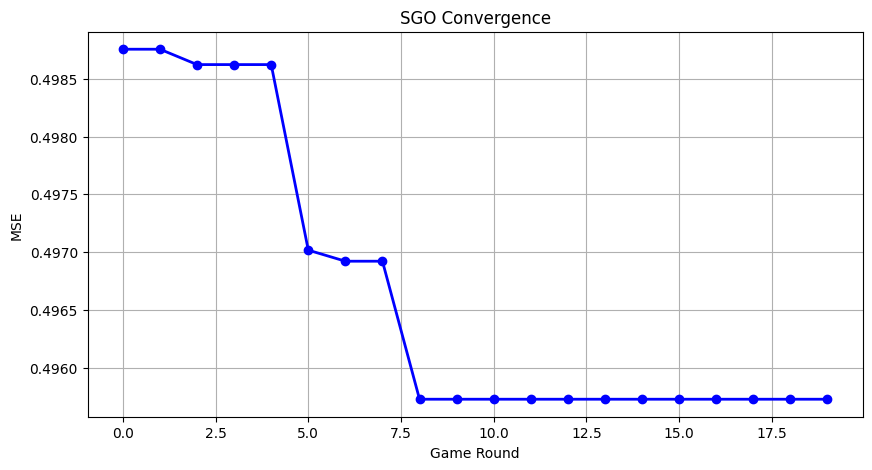

Squid Game Optimizer completed successfully with MSE: 0.4957

Running PSH-Hyptrite...

=== PSH-HYPTRITE OPTIMIZATION ===

[Initialization]
- Search points: 30
- Max iterations: 20
- Initial radius: 0.5 (adaptive)
- Hypersphere samples: 3 per point
- Search space: 14 features
- Target: Minimize MSE using XGBoost

[Optimization Progress]
Iter 20/20 | Best MSE: 0.494580 | Radius: 0.0250

=== OPTIMIZATION RESULTS ===

▶ Best MSE achieved: 0.494580
▶ Time elapsed: 714.31 seconds
▶ Features selected: 13/14 (7.1% reduction)

▶ Selected features (with weights):
1. 0 (weight: 0.854)
2. 1 (weight: 0.771)
3. 2 (weight: 0.967)
4. 3 (weight: 0.702)
5. 4 (weight: 0.554)
6. 5 (weight: 0.678)
7. 6 (weight: 0.731)
8. 7 (weight: 0.948)
9. 9 (weight: 0.657)
10. 10 (weight: 0.560)
11. 11 (weight: 0.774)
12. 12 (weight: 0.714)
13. 13 (weight: 0.746)


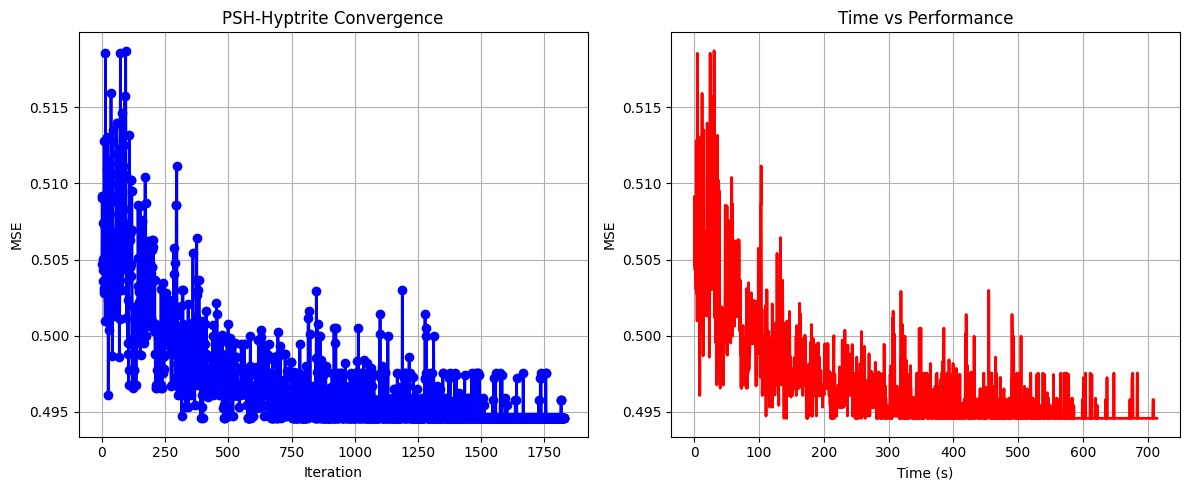

PSH-Hyptrite completed successfully with MSE: 0.4946


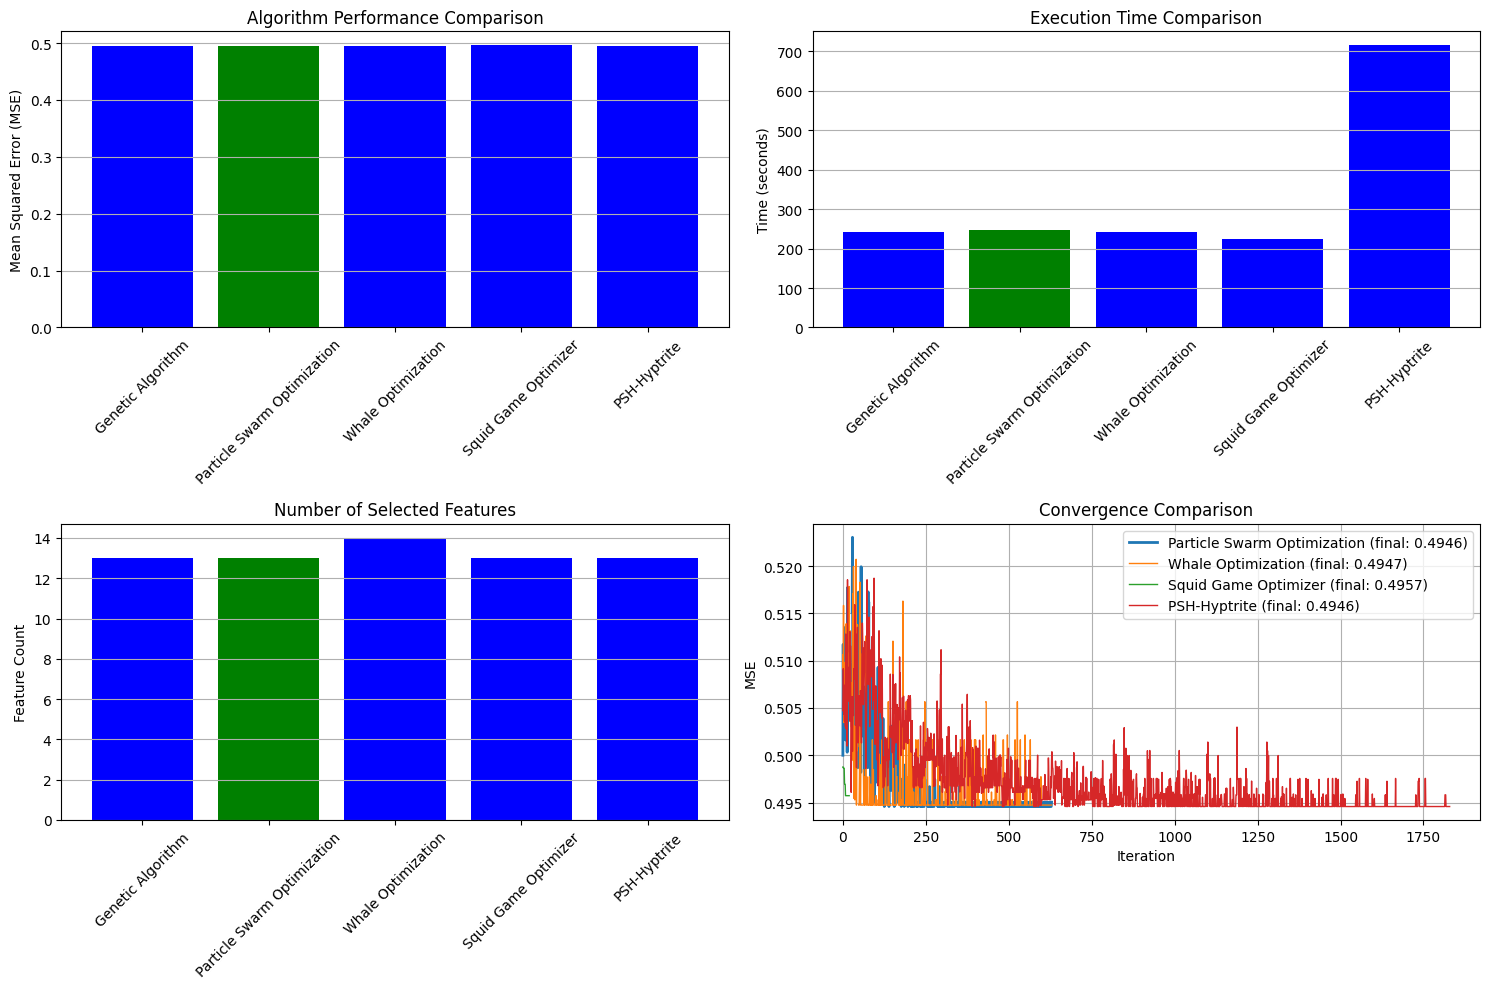


FINAL RESULTS SUMMARY

🏆 Best Algorithm: Particle Swarm Optimization
📉 Best MSE Achieved: 0.494580
⏱️ Execution Time: 245.69 seconds
🔢 Features Selected: 13

Selected Features:
1. 0
2. 1
3. 2
4. 3
5. 4
6. 5
7. 6
8. 7
9. 9
10. 10
11. 11
12. 12
13. 13


In [ ]:
best_results = select_best_algorithm(X_train, X_test, y_train, y_test)